<a href="https://colab.research.google.com/github/aditya2k5/Forecasting-electric-load-using-linear-regression_ML/blob/main/Load_prediction_best_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Aim: To find the best ML model for Load Forecasting of Electrical Load

The model we will checks are:

Linear Regression

Decision Tree Regressor

Random Forest Regressor

Gradient Boosting Regressor (XGBoost)

Support Vector Regressor (SVR)


The inputs are
1.Temperature

2.Humidity

3.WindSpeed

4.GeneralDiffuseFlows

5.DiffuseFlows

6.PowerConsumption

In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDRegressor
import json

df = pd.read_csv('loadpredictiondataset.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'], format='%m/%d/%Y %H:%M')
df['Hour'] = df['Datetime'].dt.hour
df['Day'] = df['Datetime'].dt.day
df['Month'] = df['Datetime'].dt.month
df = df.dropna()
#standardizing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
#spliting dataste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

Mean Squared Error: 17950738.25
R² Score: 0.64


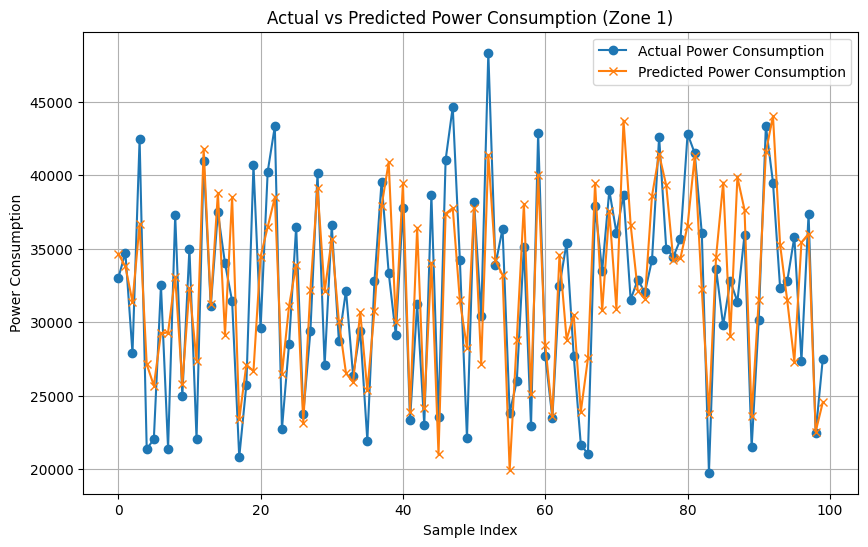

Training Size 10%, MSE: 48231803.26
Training Size 20%, MSE: 46108283.98
Training Size 30%, MSE: 44095154.22
Training Size 40%, MSE: 42241263.59
Training Size 50%, MSE: 40563269.43
Training Size 60%, MSE: 39047974.30
Training Size 70%, MSE: 37583052.67
Training Size 80%, MSE: 36305482.80
Training Size 90%, MSE: 35077059.57
Training Size 100%, MSE: 34003030.35


In [39]:
# Linear regression
features = ['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows', 'DiffuseFlows', 'Hour', 'Day', 'Month']
X = df[features]
y = df['PowerConsumption_Zone1']

#regression
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
#testing
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f}')
print(f'R² Score: {r2:.2f}')
#ploting
plt.figure(figsize=(10, 6))
plt.plot(y_test.values[:100], label='Actual Power Consumption', marker='o')
plt.plot(y_pred[:100], label='Predicted Power Consumption', marker='x')
plt.title('Actual vs Predicted Power Consumption (Zone 1)')
plt.xlabel('Sample Index')
plt.ylabel('Power Consumption')
plt.legend()
plt.grid(True)
plt.show()
# Initialize variables
n_steps = 10  # Number of pseudo-epochs (10%, 20%, ..., 100% of training data)
train_sizes = np.linspace(0.1, 1.0, n_steps)
mse_scores = []

# Train SVR on increasing training set sizes
for size in train_sizes:
    n_samples = int(len(X_train) * size)
    X_train_subset = X_train[:n_samples]
    y_train_subset = y_train[:n_samples]

    # Train SVR model
    model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    model.fit(X_train_subset, y_train_subset)

    # Compute MSE on test set
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)
    print(f'Training Size {size*100:.0f}%, MSE: {mse:.2f}')

# Save mse_scores to a JSON file
with open('mse_scores_svr.json', 'w') as f:
    json.dump(mse_scores, f)





Mean Squared Error: 3272359.15
R² Score: 0.94


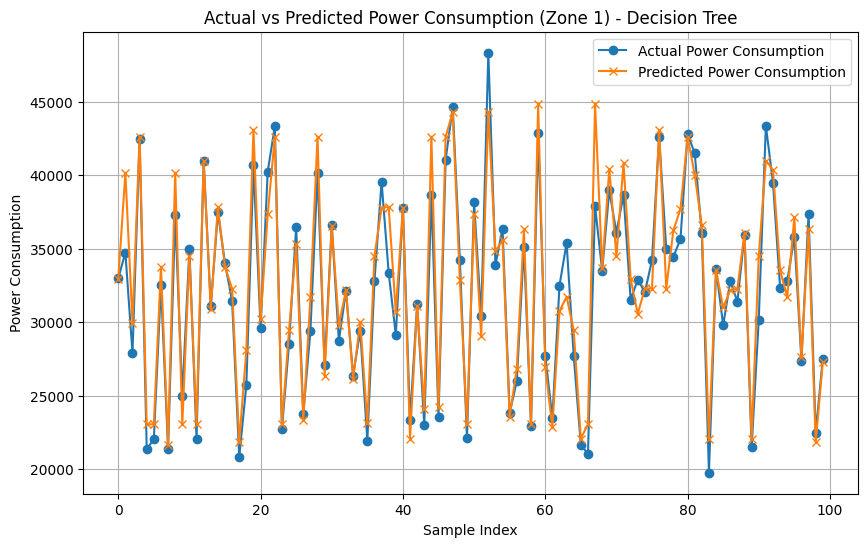

Training Size 10%, MSE: 48231803.26
Training Size 20%, MSE: 46108283.98
Training Size 30%, MSE: 44095154.22
Training Size 40%, MSE: 42241263.59
Training Size 50%, MSE: 40563269.43
Training Size 60%, MSE: 39047974.30
Training Size 70%, MSE: 37583052.67
Training Size 80%, MSE: 36305482.80
Training Size 90%, MSE: 35077059.57
Training Size 100%, MSE: 34003030.35


In [38]:
#Decision Tree Regressor model
model = DecisionTreeRegressor(max_depth=10, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
#Testing
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f}')
print(f'R² Score: {r2:.2f}')
#plotting
plt.figure(figsize=(10, 6))
plt.plot(y_test.values[:100], label='Actual Power Consumption', marker='o')
plt.plot(y_pred[:100], label='Predicted Power Consumption', marker='x')
plt.title('Actual vs Predicted Power Consumption (Zone 1) - Decision Tree')
plt.xlabel('Sample Index')
plt.ylabel('Power Consumption')
plt.legend()
plt.grid(True)
plt.show()
# Initialize variables
n_steps = 10  # Number of pseudo-epochs (10%, 20%, ..., 100% of training data)
train_sizes = np.linspace(0.1, 1.0, n_steps)
mse_scores = []

# Train SVR on increasing training set sizes
for size in train_sizes:
    n_samples = int(len(X_train) * size)
    X_train_subset = X_train[:n_samples]
    y_train_subset = y_train[:n_samples]

    # Train SVR model
    model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    model.fit(X_train_subset, y_train_subset)

    # Compute MSE on test set
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)
    print(f'Training Size {size*100:.0f}%, MSE: {mse:.2f}')

# Save mse_scores to a JSON file
with open('mse_scores_svr.json', 'w') as f:
    json.dump(mse_scores, f)

Mean Squared Error: 2694318.59
R² Score: 0.95


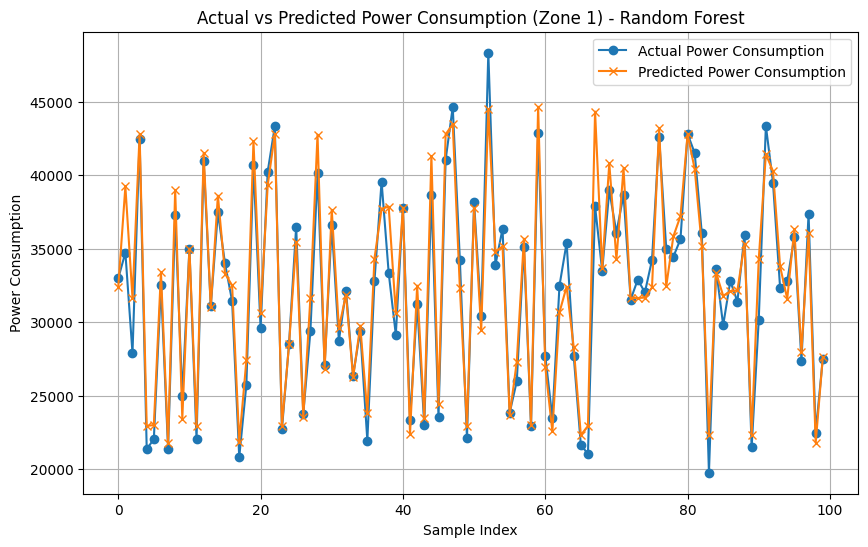

Training Size 10%, MSE: 48231803.26
Training Size 20%, MSE: 46108283.98
Training Size 30%, MSE: 44095154.22
Training Size 40%, MSE: 42241263.59
Training Size 50%, MSE: 40563269.43
Training Size 60%, MSE: 39047974.30
Training Size 70%, MSE: 37583052.67
Training Size 80%, MSE: 36305482.80
Training Size 90%, MSE: 35077059.57
Training Size 100%, MSE: 34003030.35


In [37]:
# Random Forest Regression
model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
# Testing
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f}')
print(f'R² Score: {r2:.2f}')
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(y_test.values[:100], label='Actual Power Consumption', marker='o')
plt.plot(y_pred[:100], label='Predicted Power Consumption', marker='x')
plt.title('Actual vs Predicted Power Consumption (Zone 1) - Random Forest')
plt.xlabel('Sample Index')
plt.ylabel('Power Consumption')
plt.legend()
plt.grid(True)
plt.show()
# Initialize variables
n_steps = 10  # Number of pseudo-epochs (10%, 20%, ..., 100% of training data)
train_sizes = np.linspace(0.1, 1.0, n_steps)
mse_scores = []

# Train SVR on increasing training set sizes
for size in train_sizes:
    n_samples = int(len(X_train) * size)
    X_train_subset = X_train[:n_samples]
    y_train_subset = y_train[:n_samples]

    # Train SVR model
    model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    model.fit(X_train_subset, y_train_subset)

    # Compute MSE on test set
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)
    print(f'Training Size {size*100:.0f}%, MSE: {mse:.2f}')

# Save mse_scores to a JSON file
with open('mse_scores_svr.json', 'w') as f:
    json.dump(mse_scores, f)

Mean Squared Error: 2230540.44
R² Score: 0.96


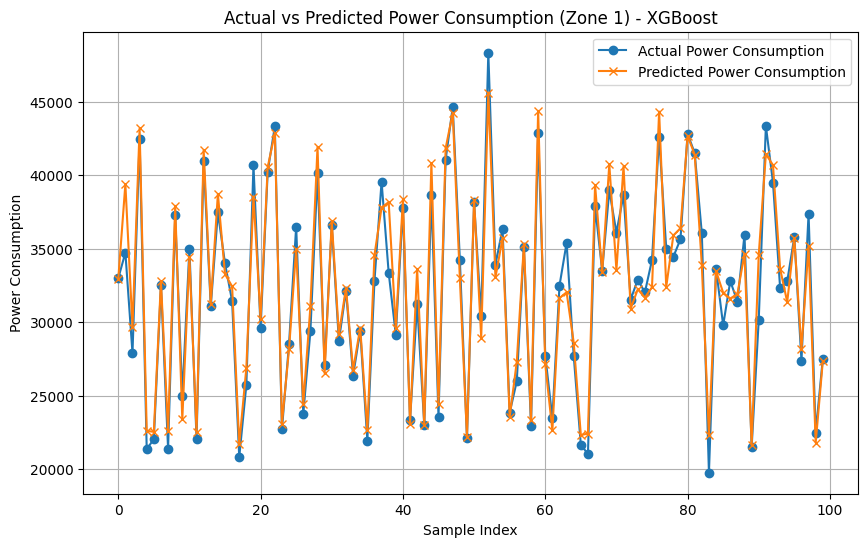

Training Size 10%, MSE: 48231803.26
Training Size 20%, MSE: 46108283.98
Training Size 30%, MSE: 44095154.22
Training Size 40%, MSE: 42241263.59
Training Size 50%, MSE: 40563269.43
Training Size 60%, MSE: 39047974.30
Training Size 70%, MSE: 37583052.67
Training Size 80%, MSE: 36305482.80
Training Size 90%, MSE: 35077059.57
Training Size 100%, MSE: 34003030.35


In [36]:
# XGBoost Regressor
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# testing
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f}')
print(f'R² Score: {r2:.2f}')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(y_test.values[:100], label='Actual Power Consumption', marker='o')
plt.plot(y_pred[:100], label='Predicted Power Consumption', marker='x')
plt.title('Actual vs Predicted Power Consumption (Zone 1) - XGBoost')
plt.xlabel('Sample Index')
plt.ylabel('Power Consumption')
plt.legend()
plt.grid(True)
plt.show()
# Initialize variables
n_steps = 10  # Number of pseudo-epochs (10%, 20%, ..., 100% of training data)
train_sizes = np.linspace(0.1, 1.0, n_steps)
mse_scores = []

# Train SVR on increasing training set sizes
for size in train_sizes:
    n_samples = int(len(X_train) * size)
    X_train_subset = X_train[:n_samples]
    y_train_subset = y_train[:n_samples]

    # Train SVR model
    model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    model.fit(X_train_subset, y_train_subset)

    # Compute MSE on test set
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)
    print(f'Training Size {size*100:.0f}%, MSE: {mse:.2f}')

# Save mse_scores to a JSON file
with open('mse_scores_svr.json', 'w') as f:
    json.dump(mse_scores, f)

Mean Squared Error: 11461068.28
R² Score: 0.77


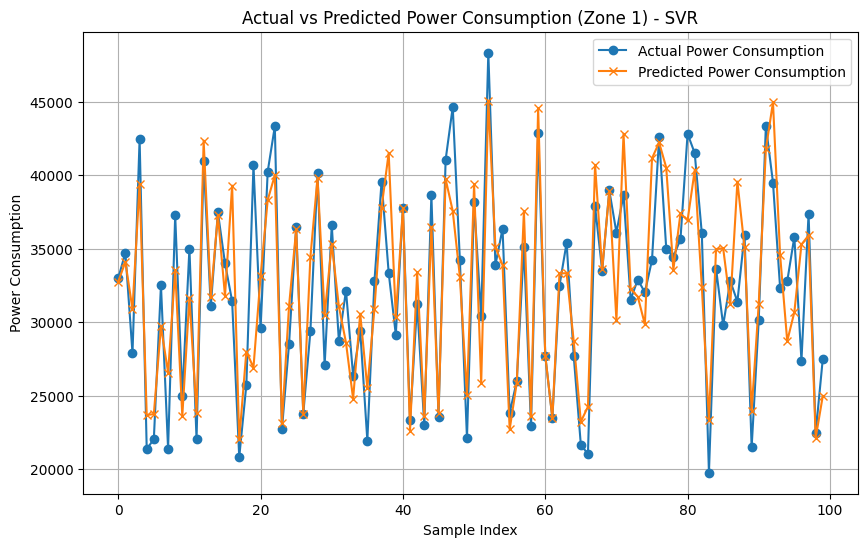

Training Size 10%, MSE: 48231803.26
Training Size 20%, MSE: 46108283.98
Training Size 30%, MSE: 44095154.22
Training Size 40%, MSE: 42241263.59
Training Size 50%, MSE: 40563269.43
Training Size 60%, MSE: 39047974.30
Training Size 70%, MSE: 37583052.67
Training Size 80%, MSE: 36305482.80
Training Size 90%, MSE: 35077059.57
Training Size 100%, MSE: 34003030.35


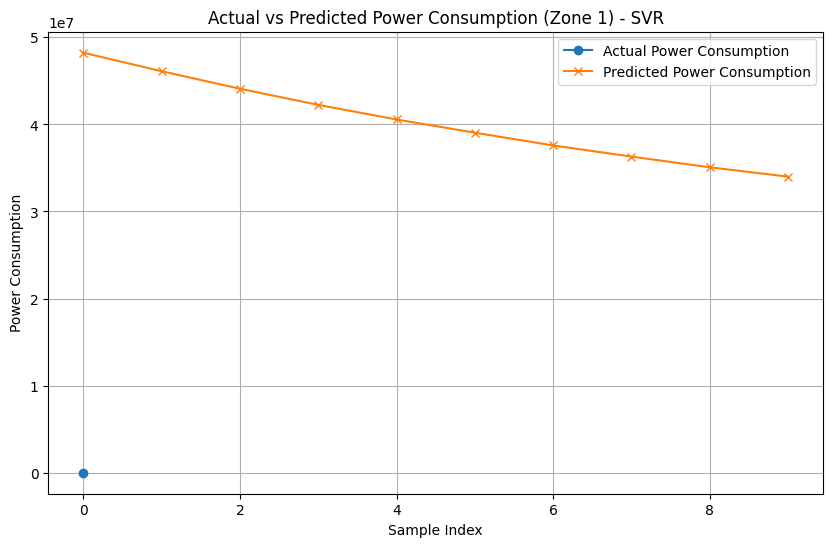

In [40]:
# Support vector regression
model = SVR(kernel='rbf', C=100, epsilon=0.1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# testing
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f}')
print(f'R² Score: {r2:.2f}')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(y_test.values[:100], label='Actual Power Consumption', marker='o')
plt.plot(y_pred[:100], label='Predicted Power Consumption', marker='x')
plt.title('Actual vs Predicted Power Consumption (Zone 1) - SVR')
plt.xlabel('Sample Index')
plt.ylabel('Power Consumption')
plt.legend()
plt.grid(True)
plt.show()
# Initialize variables
n_steps = 10  # Number of pseudo-epochs (10%, 20%, ..., 100% of training data)
train_sizes = np.linspace(0.1, 1.0, n_steps)
mse_scores = []

# Train SVR on increasing training set sizes
for size in train_sizes:
    n_samples = int(len(X_train) * size)
    X_train_subset = X_train[:n_samples]
    y_train_subset = y_train[:n_samples]

    # Train SVR model
    model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    model.fit(X_train_subset, y_train_subset)

    # Compute MSE on test set
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)
    print(f'Training Size {size*100:.0f}%, MSE: {mse:.2f}')

# Save mse_scores to a JSON file
with open('mse_scores_svr.json', 'w') as f:
    json.dump(mse_scores, f)
plt.figure(figsize=(10, 6))
plt.plot(size*100, label='Actual Power Consumption', marker='o')
plt.plot(mse_scores, label='Predicted Power Consumption', marker='x')
plt.title('Actual vs Predicted Power Consumption (Zone 1) - SVR')
plt.xlabel('Sample Index')
plt.ylabel('Power Consumption')
plt.legend()
plt.grid(True)
plt.show()